# DENSENET 121 CNN

## Setup

In [1]:
import os
import sys
import numpy as np
from pathlib import Path

In [2]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: Using Google CoLab")
except:
    print("Note: Not using Google CoLab")
    COLAB = False

if COLAB:
    if not os.path.ismount("/content/drive"):
        print("Note: Mounting drive")
        drive.mount('/content/drive')
    else:
        print("Note: Drive already mounted")

    os.system("pip install pycm")
    print("Note: pycm installed")

    sys.path.append("/content/drive/MyDrive/tumorclass.info")
    sys.path.append("/content/drive/MyDrive/tumorclass.info/notebooks")

    PROJECT_PATH = "/content/drive/MyDrive/tumorclass.info"

else:
    PROJECT_PATH = str(Path.cwd().parent)

DATA_PATH = os.path.join(PROJECT_PATH, "data/")
MODELS_PATH = os.path.join(PROJECT_PATH, "models/")
DATASET_PATH = os.path.join(PROJECT_PATH, "data/dataset/")
SRC_0_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_0/")
SRC_1_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_1/")
SRC_2_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_2/")
TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/")
TRAIN_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/normal/")
TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/lgg/")
TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/hgg/")
TEST_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/")
TEST_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/normal/")
TEST_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/lgg/")
TEST_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/hgg/")
VALID_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/")
VALID_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/normal/")
VALID_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/lgg/")
VALID_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/hgg/")
AUG_TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/")
AUG_TRAIN_NORMAL_PATH = os.path.join(
    PROJECT_PATH, "data/dataset/aug_train/normal/"
)
AUG_TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/lgg/")
AUG_TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/hgg/")

try:
    TEST_NORMAL_FILES = np.array(sorted(os.listdir(TEST_NORMAL_PATH)))
    TEST_LGG_FILES = np.array(sorted(os.listdir(TEST_LGG_PATH)))
    TEST_HGG_FILES = np.array(sorted(os.listdir(TEST_HGG_PATH)))
except FileNotFoundError:
    print("Note: No test data found! Run preprocessing.ipynb first.")

Note: Not using Google CoLab


In [3]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tools.data import (
    compare_predictions,
    confusion_matrix,
    count_params,
    enumerate_oxford,
    learning_rate_scheduler,
    p_join,
    predict_gen,
    predictor,
)
from tools.file import mkdir_if_not_exists, pickler
from tools.visualize import plot_batch, plot_epochs

In [4]:
MODEL_NAME = "cnn_densenet121"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_MODE = "rgb" # "grayscale"
IMAGE_CHANNELS = 3  # 1
CLASSES = ["normal", "lgg", "hgg"]
CLASS_MODE = "categorical"
SEED = 42

BATCH_SIZE = 24

## Prepare data

In [5]:
augment = True

train_gen = ImageDataGenerator(
).flow_from_directory(
    directory=(AUG_TRAIN_PATH if augment else TRAIN_PATH),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="training",
    shuffle=True,
    seed=SEED,
)

valid_gen = ImageDataGenerator(
).flow_from_directory(
    directory=VALID_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="validation",
    shuffle=True,
    seed=SEED,
)

test_gen = ImageDataGenerator(
).flow_from_directory(
    directory=TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False,
    seed=SEED,
)

Found 1045 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [6]:
assert train_gen.n == 1045 if augment else train_gen.n == 471
assert valid_gen.n == 204
assert test_gen.n == 60
assert (
    train_gen.num_classes
    == test_gen.num_classes
    == valid_gen.num_classes
    == 3
)

In [7]:
images, labels = next(train_gen)

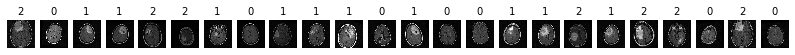

In [8]:
plot_batch(images, labels, argmax=True)

## Build Fine-tuned DENSENET 121 model

In [9]:
# # Attempt 1:

# densenet121_model = DenseNet121()

# for layer in densenet121_model.layers[:149]:
#     layer.trainable = False
# for layer in densenet121_model.layers[149:]:
#     layer.trainable = True

# model = Sequential()
# # add all layers but the last
# model.add(densenet121_model)
# # remove the last layer
# model.layers.pop()

# model.add(Dense(units=3, activation="softmax"))  #, name="predictions"))

In [10]:
# # Attempt 2:

# def DenseNet121_Model():
#     # load the DenseNet121 network, ensuring the head FC layer sets are left off
#     baseModel = DenseNet121(
#         weights="imagenet",
#         include_top=False,
#         input_tensor=Input(shape=(224, 224, 3)),
#     )
#     # construct the head of the model that will be placed on top of the the base model
#     output = baseModel.output
#     output = AveragePooling2D(pool_size=(4, 4))(output)
#     output = Flatten(name="flatten")(output)
#     output = Dense(512, activation="relu")(output)
#     output = Dropout(0.25)(output)
#     output = Dense(3, activation="softmax")(output)
#     # place the head FC model on top of the base model (this will become the actual model we will train)
#     model = Model(inputs=baseModel.input, outputs=output)
#     # loop over all layers in the base model and freeze them so they will not be updated during the first training process
#     for layer in baseModel.layers:
#         layer.trainable = False
#     return model


# model = DenseNet121_Model()

In [11]:
# # Attempt 3:

# # img_in = Input(t_x.shape[1:])
# img_in = Input(images[0].shape)
# model = DenseNet121(
#     include_top=False,
#     #layers=tf.keras.layers,
#     weights='imagenet',
#     input_tensor= img_in,
#     #input_shape= t_x.shape[1:],
#     input_shape = images[0].shape,
#     pooling ='avg'
#     )
# x = model.output
# predictions = Dense(3, activation="softmax", name="predictions")(x)
# model = Model(inputs=img_in, outputs=predictions)


In [12]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

input_tensor = Input(shape=input_shape)

# Load the DenseNet121 network, ensuring the head FC layer sets are left off.
densenet121_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    input_shape=input_shape,
    pooling=None,
    classes=1000,
)

# Construct the head of the model that will be placed on top of the the base model.
output = AveragePooling2D(pool_size=(4, 4))(densenet121_model.output)
output = Flatten(name="flatten")(output)
output = Dense(512, activation="relu")(output)
output = Dropout(0.25)(output)

prediction_layer = Dense(
    units=3,
    activation="softmax",
    name="predictions",
)(output)

model = Model(inputs=densenet121_model.input, outputs=prediction_layer)

for layer in model.layers[:-14]:
    layer.trainable = False

2022-01-08 22:14:50.794572: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

conv5_block16_0_bn
conv5_block16_0_relu
conv5_block16_1_conv
conv5_block16_1_bn
conv5_block16_1_relu
conv5_block16_2_conv
conv5_block16_concat
bn
relu
average_pooling2d
flatten
dense
dropout
predictions


In [14]:
model.summary()
params = count_params(model)
# print(f"Trainable params: {params['trainable_params']:,}")
# print(f"Non-trainable params: {params['non_trainable_params']:,}")
assert params['trainable_params'] == 694_467
assert params['non_trainable_params'] == 6_869_376

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Compile model

In [15]:
model.compile(
    optimizer=Adam(
        learning_rate=0.001,  # (0.001 * np.sqrt(0.1)),
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        amsgrad=False,
        name="Adam",
    ),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Fit model

In [16]:
epochs = 50

set_callbacks = [  # None
    # "lr_schedule",
    "lr_plateau",
    "early_stopping",
    "model_checkpoint",
]

if "lr_schedule" in set_callbacks and "lr_plateau" in set_callbacks:
    set_callbacks.pop(set_callbacks.index("lr_plateau"))
    print("Note: 'LearningRateScheduler' always wins over 'ReduceLROnPlateau'\n")

callbacks = []
callback_names = []

if set_callbacks:
    if "lr_schedule" in set_callbacks:
        learning_rate_schedule = learning_rate_scheduler(
            # epoch_steps=[5, 20],  # None,
            initial_lr=round(float(model.optimizer.learning_rate.numpy()), 8),
            # lr_steps=[0.1, 0.1],  # None,
            # use_factor=True,
            verbose=1
        )
        lr_schedule = LearningRateScheduler(learning_rate_schedule)
        model.optimizer.learning_rate = learning_rate_schedule(0)
        print(
            "[LR SCHEDULE]:\n"
            f"\tEpoch_steps: {getattr(learning_rate_schedule, 'epoch_steps')}\n"
            f"\tInitial_lr: {getattr(learning_rate_schedule, 'initial_lr')}\n"
            f"\tLr_steps: {getattr(learning_rate_schedule, 'lr_steps')}\n"
            f"\tUse_factor: {getattr(learning_rate_schedule, 'use_factor')}\n"
            )
        if getattr(learning_rate_schedule, 'use_factor'):
            epcs = getattr(learning_rate_schedule, 'epoch_steps')
            curr_step = round(float(model.optimizer.learning_rate.numpy()), 8)
            print(str(f"\tEpoch 0: {curr_step:.10f}").rstrip("0"))
            for i, step in enumerate(getattr(learning_rate_schedule, 'lr_steps')):
                curr_step *= step
                print(str(f"\tEpoch {epcs[i]}: {curr_step:.10f}").rstrip("0"))
            print()

        callbacks.append(lr_schedule)
        callback_names.append("lr_schedule")

    if "lr_plateau" in set_callbacks:
        lr_plateau = ReduceLROnPlateau(
            monitor="val_loss",
            factor=np.sqrt(0.1),
            patience=2,
            verbose=1,
            mode="auto",
            # min_delta=0.01,
            cooldown=0,
            min_lr=0.5e-6,
        )
        callbacks.append(lr_plateau)
        callback_names.append("lr_plateau")

    if "early_stopping" in set_callbacks:
        early_stopping = EarlyStopping(
            monitor="val_loss",
            # min_delta=0.01,
            patience=6,
            verbose=1,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )
        callbacks.append(early_stopping)
        callback_names.append("early_stopping")

    if "model_checkpoint" in set_callbacks:
        model_checkpoint = ModelCheckpoint(
            filepath=p_join(MODELS_PATH, MODEL_NAME + "_" + "checkpoint.hdf5"),
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
            options=None,
        )
        callbacks.append(model_checkpoint)
        callback_names.append("model_checkpoint")

print(f"Selected callbacks: {enumerate_oxford(callback_names)}")

Selected callbacks: lr_plateau, early_stopping, and model_checkpoint


In [17]:
TRAIN_STEPS_PER_EPOCH = int(train_gen.n / BATCH_SIZE)
VALID_STEPS_PER_EPOCH = int(valid_gen.n / BATCH_SIZE)
print("Train steps per epoch:", TRAIN_STEPS_PER_EPOCH)
print("Valid steps per epoch:", VALID_STEPS_PER_EPOCH)

Train steps per epoch: 43
Valid steps per epoch: 8


In [18]:
model_operation = "load"

mkdir_if_not_exists(MODELS_PATH)

clear_session()

if model_operation == "fit":
    history = model.fit(
        x=train_gen,
        epochs=epochs,
        steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
        validation_data=valid_gen,
        validation_steps=VALID_STEPS_PER_EPOCH,
        verbose=2,
        callbacks=callbacks if len(callbacks) > 0 else None,
        # workers=2,
    )

    save_model(model, os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))

    # save model history
    pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"),
        "save",
        history,
    )

elif model_operation == "load":
    model = load_model(os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))
    history = pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"), "load"
    )

elif model_operation == "checkpoint":
    model = load_model(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_checkpoint.hdf5")
    )
    history = None

## Predict

In [19]:
predictions, y_pred, y_true, target_names = predict_gen(model=model, gen=test_gen)

3/3 [==============================] - 7s 1s/step


In [20]:
predictions[0:5]

array([[9.9950945e-01, 4.4826398e-04, 4.2245028e-05],
       [9.8625481e-01, 1.2648313e-02, 1.0969475e-03],
       [9.9961227e-01, 3.8113026e-04, 6.6286520e-06],
       [9.4585538e-01, 5.3770322e-02, 3.7425323e-04],
       [9.9995244e-01, 1.3919307e-05, 3.3631200e-05]], dtype=float32)

In [21]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [22]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [23]:
target_names

['normal', 'lgg', 'hgg']

In [24]:
compare_predictions(y_pred, y_true, target_names)

[normal]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

[lgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

[hgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 
 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 



In [25]:
print(f"normal: {TEST_NORMAL_FILES[2]}")
print(f"lgg: {TEST_LGG_FILES[8]}")
print(f"hgg: {TEST_HGG_FILES[17]}")

normal: 11.jpg
lgg: 29.jpg
hgg: 58.jpg


In [26]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "normal", "1.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: NORMAL with 99.95% confidence.

Ratio
Normal: 99.95%
LGG: 0.04%
HGG: 0.00%


In [27]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "lgg", "21.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: LGG with 100.00% confidence.

Ratio
Normal: 0.00%
LGG: 100.00%
HGG: 0.00%


In [28]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "hgg", "58.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: HGG with 99.64% confidence.

Ratio
Normal: 0.03%
LGG: 0.33%
HGG: 99.64%


## Evaluate

In [29]:
eval_loss, eval_accuracy = model.evaluate(
    x=test_gen,
    batch_size=BATCH_SIZE,
    verbose=1
)

print(f"Evaluation loss: {eval_loss:.2f}")
print(f"Evaluation accuracy: {eval_accuracy*100:.2f}%")

3/3 [==============================] - 6s 1s/step - loss: 0.0254 - accuracy: 1.0000
Evaluation loss: 0.03
Evaluation accuracy: 100.00%


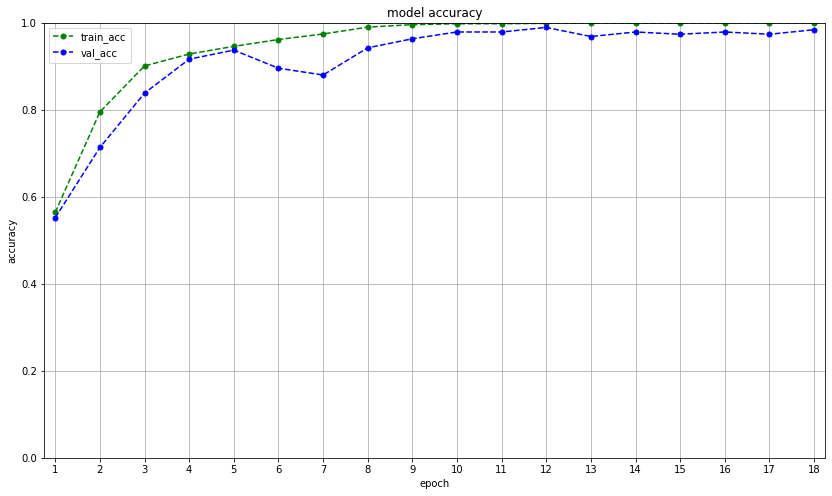

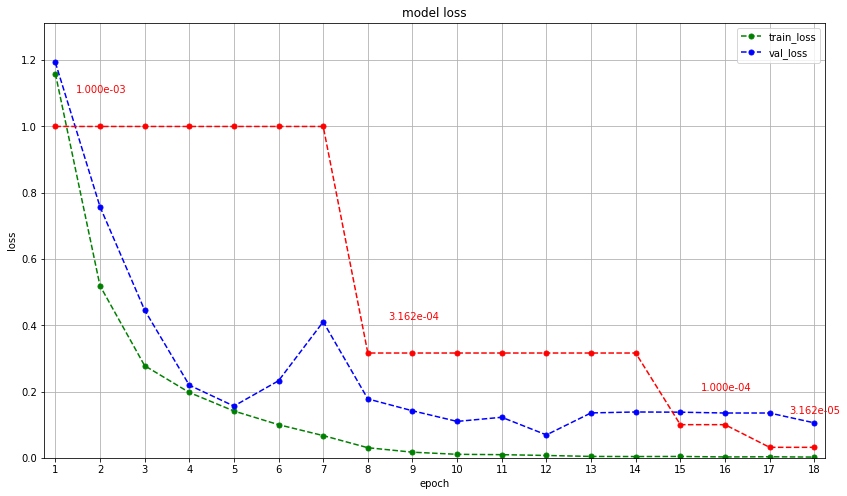

In [30]:
if history is not None:
    plot_epochs(
        history=history,
        filepath=f"{MODELS_PATH}{MODEL_NAME}",
        plot_lr=2,
        lr_x_offset=0.45,
        lr_y_offset=0.095,
        scale=1000,
    )

In [31]:
cm = confusion_matrix(
    y_pred=y_pred,
    y_true=y_true,
    labels=CLASSES,
    save=True,
    path=MODELS_PATH,
    file_name=MODEL_NAME,
)

In [32]:
cm.imbalance

False

In [33]:
# print four lines. Justify text after colon
print(
    f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}\n"
    f"{cm.Overall_ACC*100:<10.2f} {cm.PPV_Macro:<10.2f}"
    f"{cm.TPR_Macro:<10.2f} {cm.F1_Macro:<10.2f}"
)

Accuracy   Precision  Recall     F1 Score  
100.00     1.00      1.00       1.00      


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

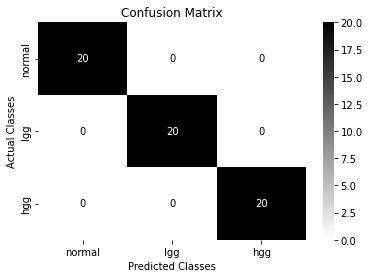

In [34]:
cm.plot(plot_lib = "seaborn", number_label=True)

<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

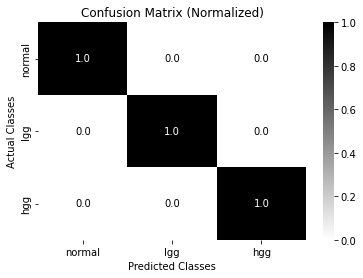

In [35]:
cm.plot(plot_lib = "seaborn", number_label=True, normalized=True)

In [36]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=target_names))


Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        20
         lgg       1.00      1.00      1.00        20
         hgg       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

